In [14]:
import numpy as np
import pandas as pd 
import seaborn as sb
from keras.preprocessing.image import ImageDataGenerator, load_img
import keras.utils 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input/garbage-classification/garbage classification/Garbage classification/"))


['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [15]:
trash = pd.read_csv("/kaggle/input/garbage-classification/zero-indexed-files.txt")


In [16]:

category = []
# index = []
filename = []
with open("../input/garbage-classification/zero-indexed-files.txt", "r") as file:
    for line in file:     
#      5>4?sd:dsds
        # Category of the image (label) e.g. glass
        cat = ''.join([i for i in line.split('.')[0] if not i.isdigit()])
        category.append(cat)
        
        
       #Image name e.g. glass/glass123.jpg
        filename.append(cat+"/"+line.split(' ')[0])
        
        
        #numerical value for category e.g. 0 for glass
#         index.append((line.split(' ')[1]).strip()

In [17]:
df = pd.DataFrame({
    'filename':filename,
    'category': category,
#     'index': index
})

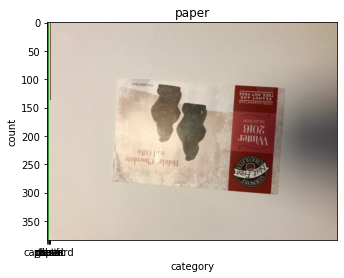

In [23]:


plt.title('Count plot')
sb.countplot(x = df['category'], data=df)
#Index 0: glass, Index 1: paper, Index 2: cardboard, Index 3: plastic, Index 4: metal, Index 5: other
#<AxesSubplot:title={'center':'Count plot'}, xlabel='category', ylabel='count'>

sample = random.choice(filename)
folder = ''.join([i for i in sample.split('.')[0] if not i.isdigit()])
    
image = load_img("../input/garbage-classification/garbage classification/Garbage classification/"+sample)
plt.title(folder.split('/')[0])
plt.imshow(image)

In [24]:


FAST_RUN = False
IMAGE_WIDTH=300
IMAGE_HEIGHT=300
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

#padding='same' returns output whose value can be computed by applying the filter to all input elements. 
#Border elements are computed using zero padding. 
#The output may be same or smaller than the input depending on the stride option.

model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),

    Flatten(),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(6, activation='softmax') #6 because we have 6 categories
])

#Computes the crossentropy loss between the labels and predictions.
#acc metric to be evaluated by the model during training and testing
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

2022-12-02 12:16:18.676443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:16:18.677541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:16:19.018502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:16:19.019562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:16:19.020447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#stop training when a monitored metric has stopped improving.
#patience: number of epochs with no improvement after which training will be stopped.
earlystop = EarlyStopping(patience=10)


In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', #quantity to be monitored (in this case total loss)
                                            patience=2, #number of epochs with no improvement after which learning rate will be reduced
                                            verbose=1, #0: quiet, 1: update messages
                                            factor=0.5, #factor by which the learning rate will be reduced
                                            min_lr=0.00001) #lower bound on the learning rate.

In [29]:
callbacks = [earlystop, learning_rate_reduction]

<AxesSubplot:xlabel='category', ylabel='count'>

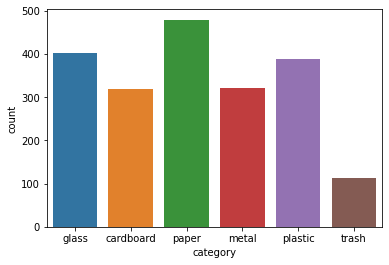

In [30]:
# df['index'] = df['category'] #.replace({0: 'glass', 1: 'paper', 2: 'cardboard', 3: 'plastic', 4: 'metal', 5: 'trash'}) 
# df.drop('index', inplace=True, axis=1)
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)#42 is the seed of randomness

#Incase a column was part of an index
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

sb.countplot(x = train_df['category'])

<AxesSubplot:xlabel='category', ylabel='count'>

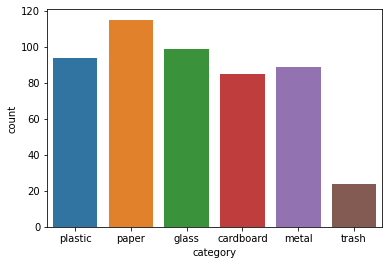

In [20]:
sb.countplot(x = validate_df['category'])

In [31]:
#.shape[0]: gives number of rows
#batch_size: number of training examples
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [32]:
train_datagen = ImageDataGenerator(
    rotation_range=15, #range for random rotations
    rescale=1./255, #rescaling factor to transform every pixel value from range [0,255] -> [0,1]
    shear_range=0.1, #shear intensity, the image will be distorted along an axis
    zoom_range=0.2, #zoom in an image
    horizontal_flip=True, #randomly flip inputs horizontally
    width_shift_range=0.1, #shift horizontally(left or right)
    height_shift_range=0.1 #shift vertically(up or down)
)

#Takes the dataframe and the path to a directory and generates batches.
#The generated batches contain augmented/normalized data.
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/garbage-classification/garbage classification/Garbage classification", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',#the type of label arrays that are returned (in this case categorical)
    batch_size=batch_size
)
# train_generator = train_datagen.flow_from_directory(
#     "../input/garbage-classification/garbage classification/Garbage classification", 
#     target_size=(300, 300),
#     batch_size=16,
#     class_mode='categorical',
#     subset='training',
#     seed=0
# )

Found 2021 validated image filenames belonging to 6 classes.


In [33]:
validation_datagen = ImageDataGenerator(rescale=1./255) #rescaling factor to transform every pixel value from range [0,255] -> [0,1]
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/garbage-classification/garbage classification/Garbage classification", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 506 validated image filenames belonging to 6 classes.


In [34]:
example_df = train_df.sample(n=1).reset_index(drop=True) #n is number of images returned
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input/garbage-classification/garbage classification/Garbage classification", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


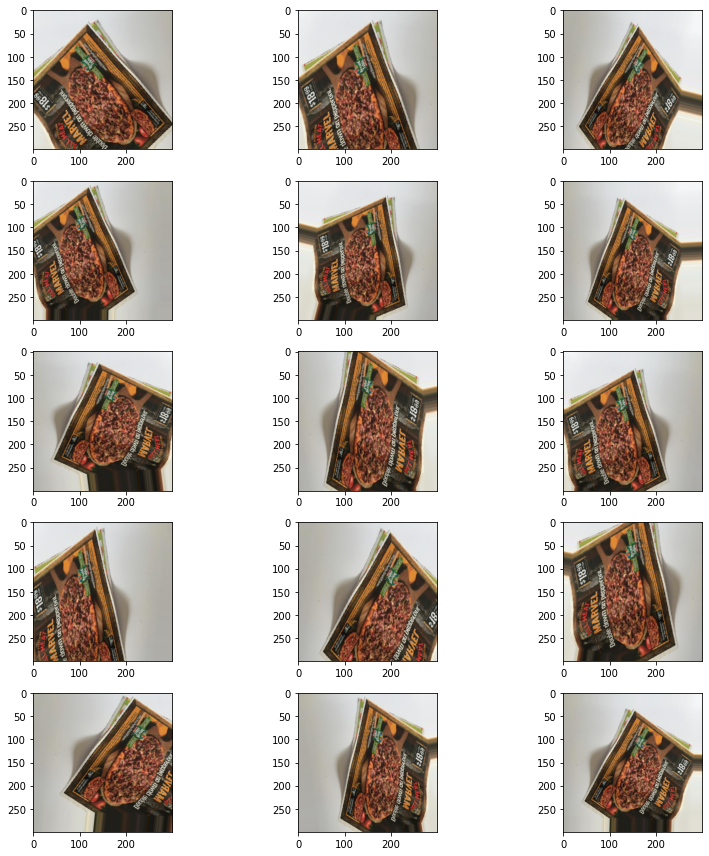

In [35]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1) #(rows,columns,index)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [36]:
model.save("model_model.h5")
model.save_weights("weight_model.h5")

In [ ]:
history = model.fit_generator(
     train_generator, 
     epochs=70,
     validation_data=validation_generator,
     validation_steps=total_validate//batch_size,#specifies total number of steps taken from the generator before it is stopped at every epoch,its value is calculated as the total number of validation data points in data divided by the validation batch size.
     steps_per_epoch=total_train//batch_size,#specifies total number of steps taken from the generator as soon as one epoch is finished and next epoch has started, its value is the total number of samples in the data divided by the batch size.
     callbacks=callbacks
 )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-02 12:42:48.157786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-12-02 12:42:51.580304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


134/134 [==============================] - 84s 520ms/step - loss: 1.9870 - acc: 0.3365 - val_loss: 4.5419 - val_acc: 0.1838
Epoch 2/70
134/134 [==============================] - 52s 386ms/step - loss: 1.6773 - acc: 0.4108 - val_loss: 2.6232 - val_acc: 0.1879


In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.show()


NameError: name 'history' is not defined

In [ ]:
test_x, test_y = validation_generator.__getitem__(1) #I think gets index 1 from dataframe (need to make sure)

labels = (train_generator.class_indices) #the mapping from class names to class indices
labels = dict((v,k) for k,v in labels.items()) #creates a dictionary by iterating through the indices

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(15):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])